In [76]:
# IMPORTS AND RANDOM SEEDS
import os
import rasterio
import rasterio.plot
from rasterio.mask import mask
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt

import geopandas as gpd
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from patchify import unpatchify
from patchify import patchify

RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)

optional_visuals = 1

In [153]:
patch_size = 128      # Size to split each training image into
patch_step = 32       # Amount to step when splitting up images for training (<size means some overlap)

percent_augment = 1   # Amount of the training data set to randomly augment (brightness, orientation)

epochs = 150          # Epochs of training for the CNN (early stopping is enabled)

## Data Import

In [238]:
path_aerials = "input/aerial/"
path_labels = "input/label/"

path_image_to_predict = "input/aerial2.tif"

In [252]:
# IMPORT AERIALS AND LABELS FROM FOLDER 
aerials = []
labels = []

# Load Full Image Aerial
with rasterio.open(path_image_to_predict) as src:
    full_image = src.read()[0:3]
    full_iamge = full_image.astype(np.float32) / 255.0

# Load in aerial images
for file in os.listdir(path_aerials):
    with rasterio.open(path_aerials + file) as src:
        image = src.read()[0:3]           # Remove 4th (alpha) band
        image.astype(np.float32) / 255.0  # Normalize to 0-1 range
        aerials.append(image) 

# Load in raster classes
for file in os.listdir(path_labels):
    with rasterio.open(path_labels + file) as src:
        labels.append(src.read()[0])

# Normalize images to 0-1
#aerials = aerials.astype(np.float32) / 255.0

print(f"Loaded {len(aerials)} aerials, with shape {aerials[0].shape}")
print(f"Loaded {len(labels)} labels, with shape {labels[0].shape}")

Loaded 4 aerials, with shape (3, 512, 512)
Loaded 4 labels, with shape (512, 512)


#### ***Optional:*** *Visualize imported data*

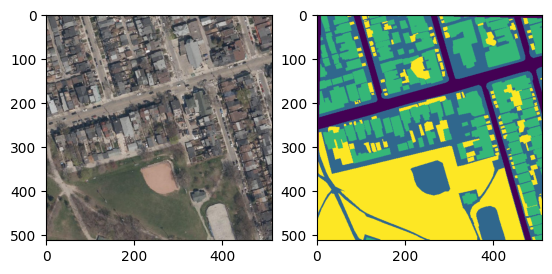

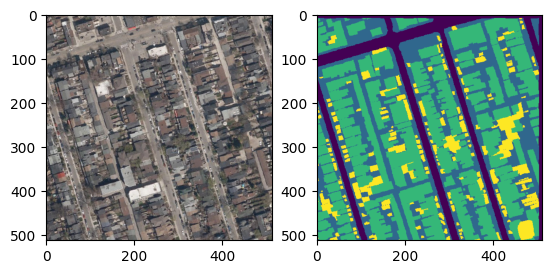

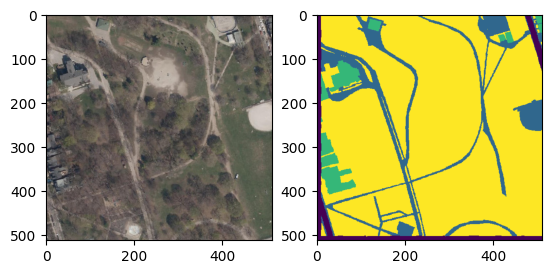

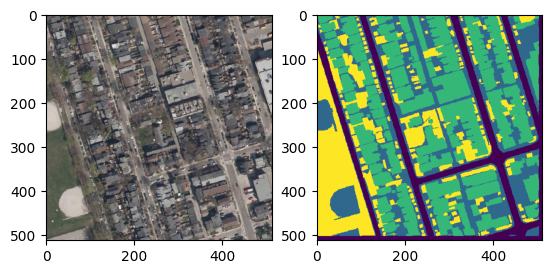

In [176]:
if optional_visuals:
    # Visualize aerials and labels
    for i in range(len(aerials)):
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(reshape_as_image(aerials[i]))
        ax[1].imshow(labels[i])

## Data Preparation
### Convert class labels to categorical (one-hot encoding)

In [214]:
# ONE HOT ENCODE
num_classes = len(np.unique(labels))
labels_encoded = to_categorical(labels, num_classes=num_classes)

print(labels_encoded.shape)

(4, 512, 512, 4)


### Train-Test split
Done before patchification so that when overlapping patches are created, there is no overlap between train/test regions

In [215]:
# TRAIN TEST SPLIT
aerial_train, aerial_test, label_train, label_test = [], [], [], []
split_x = int(aerials[0].shape[1] * 0.75) 

# Split end range of images off for testing
# This is so that when overlapping patches are created, there is no overlap between train/test regions
for i in range(len(aerials)):
    aerial_train.append(aerials[i][:, :, :split_x])
    aerial_test.append(aerials[i][:, :, split_x:])

    label_train.append(labels_encoded[i][:, :split_x, :])
    label_test.append(labels_encoded[i][:, split_x:, :])

print(f"aerial_train: {len(aerial_train), aerial_train[0].shape}")
print(f"aerial_test: {len(aerial_test), aerial_test[0].shape}")
print(f"label_train: {len(label_train), label_train[0].shape}")
print(f"label_test: {len(label_test), label_test[0].shape}")

aerial_train: (4, (3, 512, 384))
aerial_test: (4, (3, 512, 128))
label_train: (4, (512, 384, 4))
label_test: (4, (512, 128, 4))


### Create Image Patches
Patch size and step configured above

In [226]:
# CREATE OVERLAPPING PATCHES
patches_aerial_train, patches_aerial_test = [], []
patches_label_train, patches_label_test = [], []

# Patchify each train and test region
for i in range(len(aerial_train)):
    patches_aerial_train.append(patchify(aerial_train[i], (3, patch_size, patch_size), step=patch_step)[0])
    patches_aerial_test.append(patchify(aerial_test[i], (3, patch_size, patch_size), step=patch_step)[0])
    
    patches_label_train.append(patchify(label_train[i], (patch_size, patch_size, num_classes), step=patch_step))
    patches_label_test.append(patchify(label_test[i], (patch_size, patch_size, num_classes), step=patch_step))

# Convert to np array
patches_aerial_train = np.array(patches_aerial_train, dtype='float32')
patches_aerial_test = np.array(patches_aerial_test)
patches_label_train = np.array(patches_label_train)
patches_label_test = np.array(patches_label_test)

# Reshape into one list of patches
patches_aerial_train = patches_aerial_train.reshape(-1, 3, patch_size, patch_size)
patches_aerial_train = np.transpose(patches_aerial_train, (0, 2, 3, 1))

patches_aerial_test = patches_aerial_test.reshape(-1, 3, patch_size, patch_size)
patches_aerial_test = np.transpose(patches_aerial_test, (0, 2, 3, 1))

patches_label_train = patches_label_train.reshape(-1, patch_size, patch_size, num_classes)
patches_label_test = patches_label_test.reshape(-1, patch_size, patch_size, num_classes)

print(f"aerial train: {patches_aerial_train.shape}")
print(f"aerial test: {patches_aerial_test.shape}")
print(f"label train: {patches_label_train.shape}")
print(f"label test: {patches_label_test.shape}")

print(type(patches_aerial_train[0][0][0][0]))

aerial train: (468, 128, 128, 3)
aerial test: (52, 128, 128, 3)
label train: (468, 128, 128, 4)
label test: (52, 128, 128, 4)
<class 'numpy.float32'>


## Data Augmentation
U-net neural networks can have enhanced performance by augmenting training data. This section will randomize brightness, contrast, saturation, and hue, randomly horizontally flip, rotate, and zoom, and add small amounts of noise. This helps the model generalize the features.

In [229]:
def augment(image, label, brightness_factor=0.2, flip_prob=0.5, rotate_prob=0.5, noise_prob=0.5, zoom_prob=0.2):
    # Random brightness
    image = tf.image.random_brightness(image, max_delta=brightness_factor)

    # Random contrast
    image  = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Random saturation
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)

    # Random hue
    image = tf.image.random_hue(image, max_delta=0.05)
    
    # Random horizontal flipping
    if tf.random.uniform([]) < flip_prob:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)

    # Random rotation (90, 180, 270)
    if tf.random.uniform([]) < rotate_prob:
        k = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        image = tf.image.rot90(image, k=k)
        label = tf.image.rot90(label, k=k)

    # Gaussian noise
    if tf.random.uniform([]) < noise_prob:
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.02, dtype=tf.float32)
        image = tf.clip_by_value(image + noise, 0.0, 1.0)

    # Random zoon
    if tf.random.uniform([]) < zoom_prob:
        crop_factor = tf.random.uniform([], minval=0.7, maxval=1.0)
        h, w, _ = image.shape
        new_h = tf.cast(h * crop_factor, tf.int32)
        new_w = tf.cast(w * crop_factor, tf.int32)

        image = tf.image.resize_with_crop_or_pad(image, new_h, new_w)
        label = tf.image.resize_with_crop_or_pad(label, new_h, new_w)

        image = tf.image.resize(image, [h,w])
        label = tf.image.resize(label, [h,w])

    return image, label

In [233]:
# PERFORM AUGMENTATION
# Randomly select indices for augmentation
num_aug_samples = int(percent_augment * patches_aerial_train.shape[0])
augment_indices = np.random.choice(patches_aerial_train.shape[0], num_aug_samples, replace=False)

# Apply augmentation
X_aug = []
Y_aug = []

for idx in augment_indices:
    new_image, new_label = augment(patches_aerial_train[idx], patches_label_train[idx])
    X_aug.append(np.array(new_image))  
    Y_aug.append(np.array(new_label))
    
# Convert to NumPy and concatenate with original dataset
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

X_train = np.concatenate([patches_aerial_train, X_aug], axis=0)
Y_train = np.concatenate([patches_label_train, Y_aug], axis=0)

X_test = patches_aerial_test
Y_test = patches_label_test

print(f"Added {num_aug_samples} augmented images. New training total: {X_train.shape[0]}")

Added 468 augmented images. New training total: 936


## Build CNN Model
Simple U-Net architecture. Strong for image based semantic segmentation. This means it should well identify areas of each class (e.g. building, road), but will not perform instance segmentation (i.e. recognizing distinct building footprints from each other in close proximity).

In [234]:
from tensorflow.keras import layers, models

model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(128,128,3)),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.MaxPooling2D((2,2)),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),  # Upsample back

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu', padding='same'),
    layers.UpSampling2D((2,2)),

    layers.Conv2D(4, (1,1), activation='softmax')  # Output 4 classes per pixel
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
#model.summary()

### Fit the Model
Early stopping is enabled based on validation loss, so (resource permitting) epochs can be set fairly high. Configured above.

In [235]:
# Enable early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Fit the model
history = model.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test),
                    epochs=epochs, batch_size=32, 
                    callbacks=[early_stopping],
                   )

Epoch 1/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 14s 366ms/step - accuracy: 0.2790 - loss: 3.9016 - val_accuracy: 0.4120 - val_loss: 1.3092
Epoch 2/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.4599 - loss: 1.2690 - val_accuracy: 0.5150 - val_loss: 1.1246
Epoch 3/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 344ms/step - accuracy: 0.5111 - loss: 1.1384 - val_accuracy: 0.5326 - val_loss: 1.1312
Epoch 4/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 343ms/step - accuracy: 0.5269 - loss: 1.0911 - val_accuracy: 0.5373 - val_loss: 1.0924
Epoch 5/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 346ms/step - accuracy: 0.5361 - loss: 1.0575 - val_accuracy: 0.5714 - val_loss: 0.9975
Epoch 6/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 332ms/step - accuracy: 0.5550 - loss: 1.0136 - val_accuracy: 0.6348 - val_loss: 0.9128
Epoch 7/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 331ms/step - accuracy: 0.5937 - loss: 0.9470 - val_accuracy: 0.6232 - val_loss: 0.9157
Epoch 8/150
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - accuracy: 0.6141 - loss: 0.8951 - 

### Evaluate Accuracy
Check the accuracy and loss over the epochs. Mostly interested in overall validation accuracy (how well did it perform on novel test images after training).

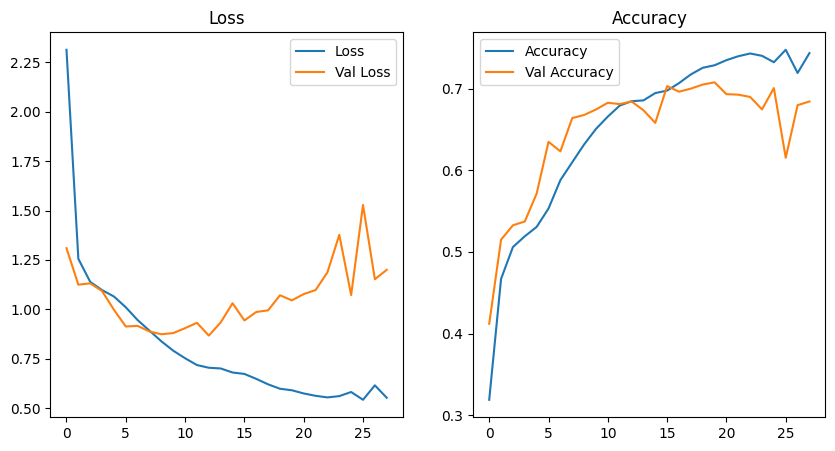

In [237]:
# Plot training loss & accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Accuracy")

plt.show()

## Predict Full Area

In [253]:
full_image_reshaped = reshape_as_image(full_image)
print("Full Image shape:", full_image_reshaped.shape)  

# Turn full image into patches to be predicted (same size and step as before)
patches_full = patchify(full_image_reshaped, (patch_size, patch_size, 3), step=patch_step)
patches_full_x, patches_full_y = patches_full.shape[0:2]

# Turn 2D array of patches into one list of patches i.e. (num_patches, patch_size, patch_size, bands)
patches_full_reshaped = patches_full.reshape(-1, patch_size, patch_size, 3)
print("Reshaped for Model shape:", patches_full_reshaped.shape)  

Full Image shape: (1920, 1920, 3)
Reshaped for Model shape: (3249, 128, 128, 3)


In [254]:
# Predict the full image
predictions = model.predict(patches_full_reshaped)
print("Predictions shape:", predictions.shape) 

predictions = predictions.reshape(patches_full.shape[0], patches_full.shape[1], patch_size, patch_size, -1)

predicted_classes = np.argmax(predictions, axis=-1)

102/102 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step
Predictions shape: (3249, 128, 128, 4)


(1952, 1952)


C:\Users\Connor\AppData\Local\Temp\ipykernel_32608\3327239446.py:20: RuntimeWarning: invalid value encountered in divide
  full_prediction /= weight_matrix
C:\Users\Connor\AppData\Local\Temp\ipykernel_32608\3327239446.py:21: RuntimeWarning: invalid value encountered in cast
  full_prediction = full_prediction.astype(np.uint8)


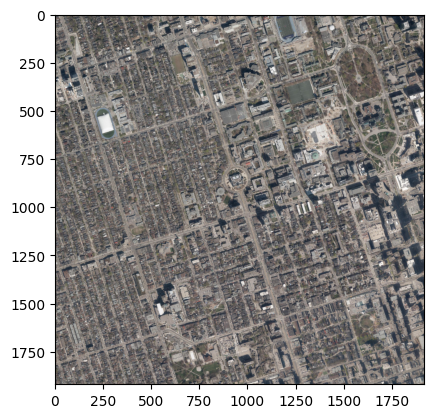

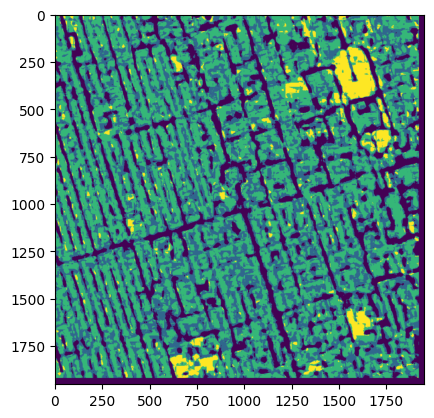

<Axes: >

In [255]:
## AVERAGE BLENDING IMPLEMENTATION
# Initialize accumulation and weight matrices
full_prediction = np.zeros((patches_full_x * patch_step + patch_size, 
                            patches_full_y * patch_step + patch_size), dtype=np.float32)
weight_matrix = np.zeros_like(full_prediction, dtype=np.float32)
print(full_prediction.shape)

# Blend patches
for i in range(patches_full_x):
    for j in range(patches_full_y):
        x_start = i * patch_step
        x_end = x_start + patch_size
        y_start = j * patch_step
        y_end = y_start + patch_size
        
        full_prediction[x_start:x_end, y_start:y_end] += predicted_classes[i, j]
        weight_matrix[x_start:x_end, y_start:y_end] += 1  # Track contributions

# Normalize by the number of times each pixel was predicted
full_prediction /= weight_matrix
full_prediction = full_prediction.astype(np.uint8)

# Patch results and display
rasterio.plot.show(full_image)
rasterio.plot.show(full_prediction)

#print(f"Average weighted blending\nTraining size: {labels_classes_raw.shape}\nPrediction size: {full_prediction.shape}\nPatch size: {patch_size}\nPatch step: {patch_step}\nAugmented: {percent_augment*100}%")